# 虚谷号WebGPIO应用（服务器端） 

虚谷号和手机（App inventor）如何互动控制？

虚谷号和掌控板如何互动控制？

为了让虚谷号和其他开源硬件、编程语言快速互动，虚谷号的WebGPIO应运而生。简单的说，只要在虚谷号上运行一个python文件，就可以用WebAPI的形式来与虚谷号互动，可以获取虚谷号板载Arduino的所有引脚的电平，也可以控制所有引脚。

## 运行服务器端代码

要在虚谷号上运行下面的代码。也可以将“webgpio.py”文件更名为“main.py”，复制到vvBoard的Python目录，只要一开机，虚谷号就会执行。

注意：
    - 如果在jupyter上运行代码，重新启动时要在“服务”中选择“重启 & 清空输出”，再运行。
    - 看到“Running on ……”的标识出现，说明服务启动正常。

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@Description: WebGPIO For vvBoard
@author: xiezuoru,james,yyp
@version: 1.1
@Date:2020.2.21
@Link: https://github.com/vvlink/vvBoard-app/tree/master/webgpio
"""

import threading
from flask import Flask
from flask import request
from xugu import Pin
from xugu import Servo
import time
import json
import socket

app = Flask(__name__)
ret = None
pin = None
types = None
pin_D_list=['D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13']
pin_A_list=['A0','A1','A2','A3','A4','A5']
type_D_list=['digital','1']
type_A_list=['analog','2']
type_S_list=['servo','3']

errhtml='''<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
            <title>WebGPIO for vvboard</title>
            <style>.c{font-size:12px;}</style>
          </head>
          <body class="c">
          <div class="c"><b>远程感知 -->> </b></div>
        <form action="" method="get" enctype="application/x-www-form-urlencoded" target="result">
            <label for="tag" class="c">引脚</label><input type="text" name="pin" value="A0" class="c">（如D2-D13，A0-A5）<br>
            <input type="submit" value=" 发送读取命令 " class="c">
        </form>
        <div class="c"><b>远程控制 -->> </b></div>
        <form action="" method="post" enctype="application/x-www-form-urlencoded" target="result">
            <label for="pin" class="c">引脚编号</label><input type="text" name="pin" value="D13" class="c">（如D2-D13）<br>
            <label for="type" class="c">控制类型</label><input type="text" name="type" value="1" class="c">（可以输入1、2、3，分别指：digital、analog和servo三种）<br>
            <label for="value" class="c">设置数值</label><input type="text" name="value" value="1" class="c">
            <input type="submit" value=" 发送控制命令 " class="c">
        </form>
        <div class="c"><a href="https://github.com/vvlink/vvBoard-app/tree/master/webgpio" target="_blank">点击这里得到详细介绍</a></div>
        <div class="c"><b>反馈显示 -->> </b></div>
        <div class="c">
            <iframe name="result" frameborder="0" scrolling="no" class="c" src=""></iframe>
        </div></body></html>'''

@app.route('/',methods=["POST","GET"])
def web_gpio():
    if (request.method == 'GET'):
        return web_gpio_get(request)
    elif (request.method=='POST'):
        return web_gpio_post(request)

def web_gpio_get(request):
    global ret,pin
    pin=request.values.get("pin")
    if not(pin):
        return errhtml
    pin=str.upper(pin)
    print("pin = ",pin)   
    if not (pin in pin_D_list or pin in pin_A_list):
        data = {"pin":pin,"error_code":1, "msg":"error,invalid Pin"}
        return json.dumps(data,indent=4,ensure_ascii=False,sort_keys=True)
    
    if pin in pin_D_list:
        ret = 0
        time.sleep(0.5)
        data = {"pin":pin,"error_code":0,"msg":str(value)}
        return json.dumps(data,indent=4,ensure_ascii=False,sort_keys=True)
    if pin in pin_A_list:
        ret = 1
        time.sleep(0.5)
        data = {"pin":pin,"error_code":0,"msg":str(value)}
        return json.dumps(data,indent=4,ensure_ascii=False,sort_keys=True)
        
def web_gpio_post(request):
    global types,pin,value
    pin=request.values.get("pin")
    types=request.values.get("type")
    if not(pin) or not(types) :
        return errhtml
    pin=str.upper(pin)
    value=request.values.get("value")
    types=str.lower(types)                      
    if not (pin in pin_D_list or pin in pin_A_list):
        data = {"pin":pin,"error_code":1,"msg":"error,invalid Pin"}
        return json.dumps(data,indent=4,ensure_ascii=False,sort_keys=True)
    try:
        value=int(value)
    except Exception:
        data = {"pin":pin,"error_code":1,"msg":"error,Value is wrong"}
        return json.dumps(data,indent=4,ensure_ascii=False,sort_keys=True)
    if not (types in type_D_list or types in type_A_list or types in type_S_list):
        data = {"pin":pin,"error_code":1,"msg":"error,Type is wrong"}
        return json.dumps(data,indent=4,ensure_ascii=False,sort_keys=True)
    data = {"pin":pin,"error_code":0,"msg":"success,set "+pin+" to "+str(value)+" with "+types+" mode"} 
    return json.dumps(data,indent=4,ensure_ascii=False,sort_keys=True)

def xugu():
    global value,ret,types
    while True:
        if ret == 0:    
            xugu_pin=Pin(pin,Pin.IN)
            value=xugu_pin.read_digital()
            ret = None
        if ret == 1:
            xugu_pin=Pin(pin,Pin.ANALOG)
            value=xugu_pin.read_analog()
            ret = None
        if types in type_D_list:
            xugu_pin=Pin(pin,Pin.OUT)
            if value == 0:
                xugu_pin.write_digital(value)
            else:
                value = 1
                xugu_pin.write_digital(value)
            types=None
        if types in type_A_list:
            xugu_pin=Pin(pin,Pin.OUT)
            xugu_pin.write_analog(value)
            types=None
        if types in type_S_list:
            xugu_servo=Servo(pin)
            xugu_servo.write_angle(value)
            types=None
            
def get_host_ip():
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(('8.8.8.8', 80))
        ip = s.getsockname()[0]
    finally:
        s.close()
    return ip
                
def run():
    app.run(host=get_host_ip(),port=1024,debug=False)   

t=threading.Thread(target=run)
t.start()
xugu()


pymata_aio Version 2.28	Copyright (c) 2015-2018 Alan Yorinks All rights reserved.

Using COM Port:/dev/ttyS1

Initializing Arduino - Please wait... 
Arduino Firmware ID: 2.5 StandardFirmata.ino
Auto-discovery complete. Found 20 Digital Pins and 6 Analog Pins


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://192.168.3.42:1024/ (Press CTRL+C to quit)
192.168.3.42 - - [21/Feb/2020 22:08:35] "POST /?pin=D13&type=1&value=1 HTTP/1.1" 200 -
192.168.3.42 - - [21/Feb/2020 22:09:02] "POST /?pin=D13&type=1&value=1 HTTP/1.1" 200 -
192.168.3.42 - - [21/Feb/2020 22:09:26] "POST /?pin=D13&type=1&value=1 HTTP/1.1" 200 -


pin =  D13


192.168.3.42 - - [21/Feb/2020 22:10:20] "GET /?pin=D13 HTTP/1.1" 200 -


pin =  D13


192.168.3.42 - - [21/Feb/2020 22:11:28] "GET /?pin=D13 HTTP/1.1" 200 -
192.168.3.14 - - [21/Feb/2020 22:12:52] "POST /?pin=D13&value=1&type=1 HTTP/1.1" 200 -
192.168.3.14 - - [21/Feb/2020 22:21:48] "POST /?pin=D13&value=1&type=1 HTTP/1.1" 200 -


访问程序中提示的网址，将会看到这样的页面。接下来就开始自由控制虚谷号吧。

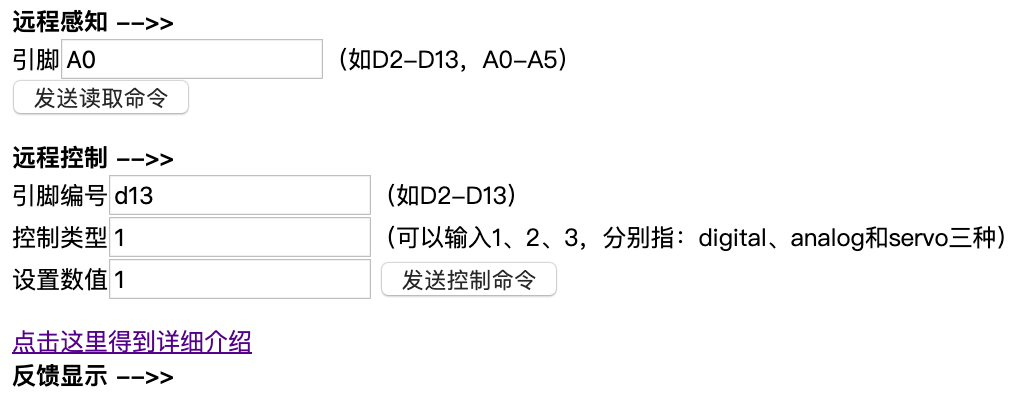